# <center>Monocular Depth Estimation

In [28]:
from zipfile import ZipFile
import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
import pywt

In [29]:
split = 0.8
height, width = 240, 240 #480, 480 # 240, 320

#### Downloading Data

In [30]:
train_df = pd.read_csv("/home/ajay/nyu_data/data/nyu2_train.csv",header=None)

In [31]:
train_df

,0,1
0,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png
1,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png
2,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png
3,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png
4,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png
...,...,...
50683,data/nyu2_train/dining_room_0031_out/441.jpg,data/nyu2_train/dining_room_0031_out/441.png
50684,data/nyu2_train/dining_room_0031_out/365.jpg,data/nyu2_train/dining_room_0031_out/365.png
50685,data/nyu2_train/dining_room_0031_out/447.jpg,data/nyu2_train/dining_room_0031_out/447.png
50686,data/nyu2_train/dining_room_0031_out/90.jpg,data/nyu2_train/dining_room_0031_out/90.png


In [32]:
test = pd.read_csv("/home/ajay/nyu_data/data/nyu2_test.csv",header=None)

In [33]:
test

,0,1
0,data/nyu2_test/00000_colors.png,data/nyu2_test/00000_depth.png
1,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png
2,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png
3,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png
4,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png
...,...,...
649,data/nyu2_test/01444_colors.png,data/nyu2_test/01444_depth.png
650,data/nyu2_test/01445_colors.png,data/nyu2_test/01445_depth.png
651,data/nyu2_test/01446_colors.png,data/nyu2_test/01446_depth.png
652,data/nyu2_test/01447_colors.png,data/nyu2_test/01447_depth.png


In [34]:
train_df = pd.read_csv("/home/ajay/nyu_data/data/nyu2_train.csv",header=None).rename(columns = {0:'image',1:'depth'})
test = pd.read_csv("/home/ajay/nyu_data/data/nyu2_test.csv",header=None).rename(columns = {0 : 'image',1:'depth'})

In [35]:
train_df

,image,depth
0,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png
1,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png
2,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png
3,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png
4,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png
...,...,...
50683,data/nyu2_train/dining_room_0031_out/441.jpg,data/nyu2_train/dining_room_0031_out/441.png
50684,data/nyu2_train/dining_room_0031_out/365.jpg,data/nyu2_train/dining_room_0031_out/365.png
50685,data/nyu2_train/dining_room_0031_out/447.jpg,data/nyu2_train/dining_room_0031_out/447.png
50686,data/nyu2_train/dining_room_0031_out/90.jpg,data/nyu2_train/dining_room_0031_out/90.png


In [36]:
test

,image,depth
0,data/nyu2_test/00000_colors.png,data/nyu2_test/00000_depth.png
1,data/nyu2_test/00001_colors.png,data/nyu2_test/00001_depth.png
2,data/nyu2_test/00008_colors.png,data/nyu2_test/00008_depth.png
3,data/nyu2_test/00013_colors.png,data/nyu2_test/00013_depth.png
4,data/nyu2_test/00014_colors.png,data/nyu2_test/00014_depth.png
...,...,...
649,data/nyu2_test/01444_colors.png,data/nyu2_test/01444_depth.png
650,data/nyu2_test/01445_colors.png,data/nyu2_test/01445_depth.png
651,data/nyu2_test/01446_colors.png,data/nyu2_test/01446_depth.png
652,data/nyu2_test/01447_colors.png,data/nyu2_test/01447_depth.png


In [37]:
train_split = int(len(train_df)*split)

In [38]:
train = train_df[:train_split]
validation = train_df[train_split:]

In [39]:
len(train), len(validation) ,len(test)

(40550, 10138, 654)

#### Preprocessing

In [40]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False, dim=(240,240)):
        np.random.seed(43)
        self.df = dataframe
        self.height, self.width = dim
        self.shuffle = shuffle
        self.batch_size = batch_size
        # unique set of RGB images
        self.ids = dataframe['image'].unique()
        # Map the image with depth maps
        self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
  
    def __getitem__(self,index):
        idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size] # select the batch of pair indexes 
        flip = np.random.choice([True, False])  # randomly select whether to flip the image
        query_imgs = [self.ids[idx] for idx in idxs]  # select the image id's for the above indexes
        target_imgs = [self.imgtodpth[img] for img in query_imgs]  # select corresponding depth pair for the image
        processed_query_img = self._preprocess_image(query_imgs, flip) # preprocess the image
        processed_depth_img = self._preprocess_depth(target_imgs, flip)  # preprocess the depth map
        return processed_query_img, processed_depth_img

    def _preprocess_image(self,images, flip):
        # placeholder for storing the processed images
        processed = []
        sze=240
        for img in images:
            # resize the image to 640x480
            resized_img = cv2.resize(cv2.imread("/home/ajay/nyu_data/" + img),(self.height,self.width)).astype(np.float32)
            # normalize the image to {0,1}
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            # flip the image horizontally
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            processed.append(scaled_img)
        return np.array(processed)

    def _preprocess_depth(self,images, flip):
        # placeholder for storing the processed depth maps
        processed = []
        sze=240
        for img in images:
            # resize the depth map to 320x240
            resized_img = cv2.resize(cv2.cvtColor(cv2.imread("/home/ajay/nyu_data/" + img), cv2.COLOR_BGR2GRAY),(self.height,self.width)).astype(np.float32)
            # normalize it to range {0,1}
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            # flip the image horizontally
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
                # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
            scaled_img = np.expand_dims(scaled_img, axis=-1)
            # finally append the image
            processed.append(scaled_img)
        return np.array(processed)   


In [41]:
train_generator = DataGenerator(train, batch_size=8, shuffle=False, dim=(240,240))
val_generator = DataGenerator(validation, batch_size=8, shuffle=False, dim=(240,240))
test_generator = DataGenerator(test, batch_size=8, shuffle=False, dim=(240,240))
print(len(train_generator), len(val_generator),len(test_generator))   

5068 1267 81


In [42]:
images,depths = next(iter(train_generator))
print(images.shape, depths.shape)

(8, 240, 240, 3) (8, 240, 240, 1)


In [43]:
my_image,my_depth = next(iter(test_generator))
print(my_image.shape, my_depth.shape)

(8, 240, 240, 3) (8, 240, 240, 1)


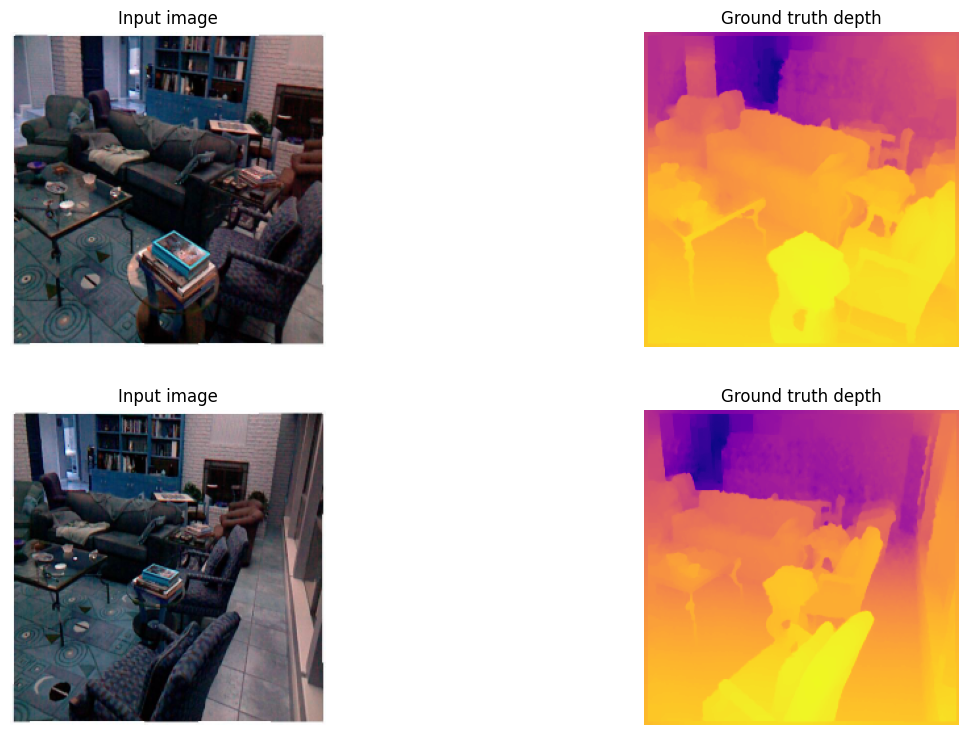

In [44]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
    image = images[i]
    depth = depths[i].squeeze(-1)
    plt.subplot(221+i)
    plt.axis('off')
    plt.imshow(image)
    plt.title('Input image')
    plt.subplot(222+i)
    plt.axis('off')
    plt.imshow(depth,cmap=plt.get_cmap(cmap))
    plt.title('Ground truth depth')

In [45]:
print(len(train_generator), len(test_generator))
images,depths = next(iter(test_generator))
print(images.shape, depths.shape)
images,depths = next(iter(train_generator))
print(images.shape, depths.shape)

5068 81
(8, 240, 240, 3) (8, 240, 240, 1)
(8, 240, 240, 3) (8, 240, 240, 1)


#### Defining Loss Function 

In [46]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

def loss_function(y_true, y_pred):
    theta=0.1
    maxDepthVal=1000.0/10.0
    LapFilter = K.constant([[[[0]], [[-1 ]], [[0 ]]], [[[-1]], [[5 ]], [[-1 ]]], [[[0 ]], [[-1 ]], [[0 ]]]])
    #Cosine distance loss
    #l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)
    # edge loss for sharp edges
    #dy_true, dx_true = tf.image.image_gradients(y_true)
    #dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    #l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
    s_true  = tf.image.sobel_edges(y_true)
    s_pred  = tf.image.sobel_edges(y_pred)
    l_edges = K.mean(K.mean(K.abs((s_pred[...,0]/4+0.5) - (s_true[...,0]/4+0.5)) + K.abs((s_pred[...,1]/4+0.5) - (s_true[...,1]/4+0.5)), axis=-1))
    # structural similarity loss
    inputChannels = K.reshape(K.ones_like(y_true[0,0,0,:]),(1,1,-1,1))
    filt = LapFilter * inputChannels
    LapTrue = K.depthwise_conv2d(y_true,filt, padding='same' ) 
    LapTrue =tf.clip_by_value(LapTrue, clip_value_min=0.0, clip_value_max=1.0) 
    l_ssim = K.clip((1 - tf.image.ssim(LapTrue, y_pred, maxDepthVal)) * 0.5, 0, 1)
    #l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 1, 0, 1)

    # weightage
    w1, w2, w3 = 1.0, 1.0, 0.1
    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))



In [47]:
#optimizer
#opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
#def accuracy_function(y_true, y_pred):
#    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler

#def polynomial_decay(epoch):
#    max_epochs = 20
#    base_lr =  0.0002
#    power = 1.0
 #   lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
#    return lr

# save model frequently for later use.
#checkpoint = tf.keras.callbacks.ModelCheckpoint('densenet_final', save_best_only=True, verbose=1)
#callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint]


# 

# <center> UNet(Training without Batch normalisetion)

In [67]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


def unet(input_size = (240,240,3)):
    #inputs = Input(input_size)
    inputs = layers.Input(input_size, dtype=tf.float32)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = models.Model(inputs,conv10 ,name = "UNet")
    #print(model.summary())

    return model

In [68]:
from datetime import datetime
input_img = (240,240, 3)
model = unet(input_img)
checkpoint = tf.keras.callbacks.ModelCheckpoint('check2.h5',save_best_only=True,verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 5
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr

opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint] #reduce_lr, early_stopping]
# model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs=2,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('unet2.h5')

2023-03-01 12:25:04.991745: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.00MiB (rounded to 18874368)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-03-01 12:25:04.991812: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-03-01 12:25:04.991838: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 30, Chunks in use: 30. 7.5KiB allocated for chunks. 7.5KiB in use in bin. 640B client-requested in use in bin.
2023-03-01 12:25:04.991853: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2023-03-01 12:25:04.991867: I tensorflow/tsl/framework/bfc_allocator

RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL _NotOkStatusException REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/eager/core.py(36): __init__
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py(6577): mul
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py(529): multiply
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py(1176): op_dispatch_handler
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py(1767): _mul_dispatch
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py(1407): binary_op_wrapper
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/stateless_random_ops.py(833): stateless_truncated_normal
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py(1176): op_dispatch_handler
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/backend.py(2142): truncated_normal
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/initializers/initializers_v2.py(652): _generate_init_val
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/initializers/initializers_v2.py(637): __call__
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py(1905): _init_from_args
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py(1721): __init__
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/variables.py(273): __call__
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/variable_scope.py(2706): default_variable_creator
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/variables.py(203): <lambda>
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/variables.py(210): _variable_v1_call
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/ops/variables.py(269): __call__
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/engine/base_layer_utils.py(134): make_variable
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tensorflow/python/trackable/base.py(489): _add_variable_with_custom_getter
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/engine/base_layer.py(711): add_weight
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py(220): build
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/engine/base_layer.py(2986): _maybe_build
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/engine/base_layer.py(2439): _infer_output_signature
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/engine/base_layer.py(2382): _keras_tensor_symbolic_call
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/engine/base_layer.py(2535): _functional_construction_call
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/engine/base_layer.py(1045): __call__
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/keras/utils/traceback_utils.py(65): error_handler
  /tmp/ipykernel_439228/3215920839.py(35): unet
  /tmp/ipykernel_439228/1137828944.py(3): <module>
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3460): run_code
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3400): run_ast_nodes
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3221): run_cell_async
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3016): _run_cell
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2961): run_cell
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel/zmqshell.py(528): run_cell
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel/ipkernel.py(383): do_execute
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel/kernelbase.py(730): execute_request
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel/kernelbase.py(499): process_one
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/asyncio/events.py(80): _run
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/asyncio/base_events.py(1905): _run_once
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/asyncio/base_events.py(601): run_forever
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/tornado/platform/asyncio.py(199): start
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel/kernelapp.py(712): start
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/traitlets/config/application.py(1043): launch_instance
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/site-packages/ipykernel_launcher.py(17): <module>
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/runpy.py(87): _run_code
  /home/vr-lab/anaconda3/envs/SC21M001/lib/python3.9/runpy.py(197): _run_module_as_main


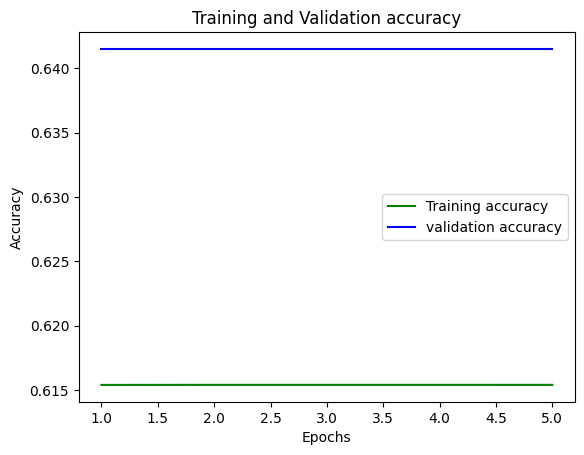

In [ ]:
loss_train = history.history['accuracy_function']
loss_val = history.history['val_accuracy_function']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

from tensorflow.keras.models import load_model
new_model =load_model('unet2.h5', 
                      custom_objects = {'loss_function':loss_function,'accuracy_function':accuracy_function})

2023-02-08 21:53:09.497579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 21:53:10.981186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15787 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-02-08 21:53:10.982243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14322 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


In [ ]:
print(new_model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 240, 240, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 240, 240, 12  0          ['conv2d_18[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 240, 240, 64  32832       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 240, 240, 12  0           ['conv2d_1[0][0]',               
                                8)                                'conv2d_19[0][0]']              
                                                                                                  
 conv2d_20

In [ ]:
new_model.load_weights('check2.h5')

In [ ]:
import numpy as np
from zipfile import ZipFile
from io import BytesIO

def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}
data = extract_zip('nyu_test.zip')
    
my_rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
my_depth = np.load(BytesIO(data['eigen_test_depth.npy']))
test_crop = np.load(BytesIO(data['eigen_test_crop.npy']))
print('Test data loaded.\n')

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth, maxDepth, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return predictions
    #return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth
    
    
test_rgb = tf.image.resize(my_rgb,[240,240])
im = tf.expand_dims(my_depth, axis=3)
test_depth = tf.image.resize(im,[240,240])/10

test_pred = predict(new_model,test_rgb/255, minDepth=10 ,maxDepth=1000, batch_size=6)

def compute_errors(gt, pred):
    err_name = ['a1','a2','a3','abs_rel','rmse','log_10']
    err_val = []
    
    thresh = np.maximum((gt / pred), (pred / gt))
        
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(np.mean(rmse))

    log_10 = np.mean((np.abs(np.log10(gt)-np.log10(pred))))
    
    err_val.extend([a1,a2,a3,abs_rel,rmse,log_10])
    
    
    d = dict(zip(err_name,err_val))
    
    for k,v in d.items():
        print(f"{k} : {v}")
        
compute_errors(test_depth, test_pred)
        
#depth_scores = np.zeros((6, len(rgb)))

#e = depth_scores.mean(axis=1)

#print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))


Test data loaded.



2023-02-08 21:55:19.490516: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


109/109 [==============================] - 9s 42ms/step
a1 : 0.2329735017414203
a2 : 0.47584992460924225
a3 : 0.6826728943679918
abs_rel : 0.8114866018295288
rmse : 0.17374275624752045
log_10 : 0.23062260448932648


# 

# <center>1. Unet Architecture

In [21]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    return conv

In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True): 
    
    FILTER_NUM = 64 
    FILTER_SIZE = 3 
    UP_SAMP_SIZE = 2 
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
   
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8) #Conv2DTranspose
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
 
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128) # size=1/input_img[2],padding="same"
    conv_final = layers.BatchNormalization(axis=3)(conv_final)              # no
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel    no

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    #print(model.summary())
    return model

In [ ]:
from datetime import datetime
input_img = (240,240, 3)
model = UNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('ucheck1.h5', save_best_only=True, verbose=1)

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 70
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

csv_log1 = tf.keras.callbacks.CSVLogger('my_log1.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,csv_log1] #reduce_lr, early_stopping]
#model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs= 60 ,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('unet1.h5')

In [22]:
x = pd.read_csv("my_log22.csv")
x

,epoch,accuracy_function,loss,lr,val_accuracy_function,val_loss
0,0,0.702014,0.058885,0.00020,0.706189,0.059176
1,1,0.754750,0.051277,0.00019,0.706816,0.061742
2,2,0.786020,0.046466,0.00018,0.759762,0.048725
3,3,0.818001,0.041615,0.00017,0.757375,0.048520
4,4,0.848151,0.037617,0.00016,0.776848,0.048043
5,5,0.871502,0.034353,0.00015,0.792554,0.044433
6,6,0.888660,0.031747,0.00014,0.798706,0.043363
7,7,0.902178,0.029600,0.00013,0.800595,0.042876
8,8,0.912126,0.027889,0.00012,0.811956,0.041410
9,9,0.920072,0.026427,0.00011,0.809622,0.041157


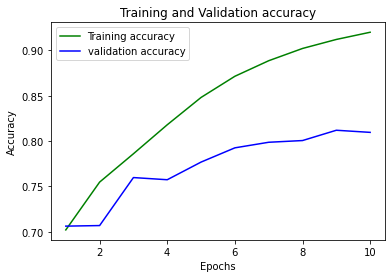

In [24]:
loss_train = x['accuracy_function']
loss_val = x['val_accuracy_function']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

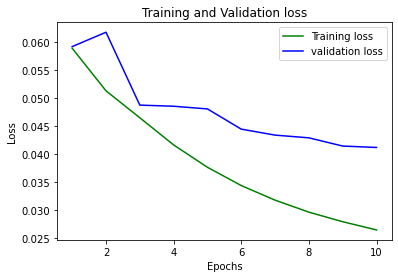

In [25]:
loss_train = x['loss']
loss_val = x['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Prediction 

In [26]:
from tensorflow.keras.models import load_model
new_model =load_model('mod_unet2.h5', 
                      custom_objects = {'loss_function':loss_function,'accuracy_function':accuracy_function})

In [27]:
print(new_model.summary())

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_110 (Conv2D)            (None, 320, 320, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_110 (Batch  (None, 320, 320, 64  256        ['conv2d_110[0][0]']             
 Normalization)                 )                                                              

 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 80, 80, 256)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 40, 40, 256)  0          ['activation_118[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_119 (Conv2D)            (None, 40, 40, 512)  1180160     ['max_pooling2d_21[0][0]']       
                                                                                                  
 batch_normalization_119 (Batch  (None, 40, 40, 512)  2048       ['conv2d_119[0][0]']             
 Normaliza

 Normalization)                 )                                                                 
                                                                                                  
 activation_127 (Activation)    (None, 10, 10, 2048  0           ['batch_normalization_127[0][0]']
                                )                                                                 
                                                                                                  
 up_sampling2d_19 (UpSampling2D  (None, 20, 20, 2048  0          ['activation_127[0][0]']         
 )                              )                                                                 
                                                                                                  
 concatenate_19 (Concatenate)   (None, 20, 20, 3072  0           ['up_sampling2d_19[0][0]',       
                                )                                 'activation_124[0][0]']         
          

 activation_135 (Activation)    (None, 80, 80, 256)  0           ['batch_normalization_135[0][0]']
                                                                                                  
 conv2d_136 (Conv2D)            (None, 80, 80, 256)  590080      ['activation_135[0][0]']         
                                                                                                  
 batch_normalization_136 (Batch  (None, 80, 80, 256)  1024       ['conv2d_136[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_136 (Activation)    (None, 80, 80, 256)  0           ['batch_normalization_136[0][0]']
                                                                                                  
 up_sampling2d_22 (UpSampling2D  (None, 160, 160, 25  0          ['activation_136[0][0]']         
 )        

Total params: 188,725,125
Trainable params: 188,689,027
Non-trainable params: 36,098
__________________________________________________________________________________________________
None


In [28]:
new_model.load_weights('mod_ucheck2.h5')

In [ ]:
import numpy as np
from zipfile import ZipFile
from io import BytesIO

def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}
data = extract_zip('nyu_test.zip')
    
my_rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
my_depth = np.load(BytesIO(data['eigen_test_depth.npy']))
test_crop = np.load(BytesIO(data['eigen_test_crop.npy']))
print('Test data loaded.\n')

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth, maxDepth, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return predictions
    #return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth
    
    
test_rgb = tf.image.resize(my_rgb,[320,320])
im = tf.expand_dims(my_depth, axis=3)
test_depth = tf.image.resize(im,[320,320])/10

test_pred = predict(new_model,test_rgb/255, minDepth=10 ,maxDepth=1000, batch_size=6)

def compute_errors(gt, pred):
    err_name = ['a1','a2','a3','abs_rel','rmse','log_10']
    err_val = []
    
    thresh = np.maximum((gt / pred), (pred / gt))
        
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(np.mean(rmse))

    log_10 = np.mean((np.abs(np.log10(gt)-np.log10(pred))))
    
    err_val.extend([a1,a2,a3,abs_rel,rmse,log_10])
    
    
    d = dict(zip(err_name,err_val))
    
    for k,v in d.items():
        print(f"{k} : {v}")
        
compute_errors(test_depth, test_pred)


Test data loaded.

108/109 [============================>.] - ETA: 16s

Text(0.5, 1.0, 'Predicted_Depth')

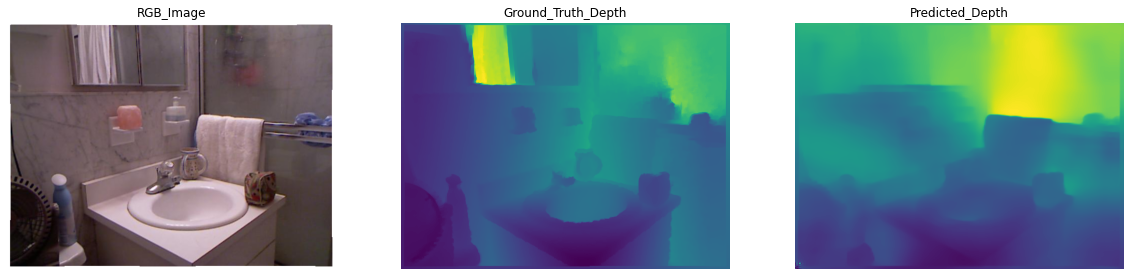

In [56]:

# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# reading images
Image1 = my_rgb[0,:,:,:]
Image2 = my_depth[0,:,:]
Image3 = test_pre[0,:,:,:]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("RGB_Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Ground_Truth_Depth")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Predicted_Depth")

# 

# <center>2.  Attention UNet

In [48]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [49]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [50]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [51]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [27]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

In [28]:
from datetime import datetime
input_img = (240,240, 3)
model = Attention_UNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('atucheck3.h5', save_best_only=True, verbose=1)

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 70
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

csv_log3 = tf.keras.callbacks.CSVLogger('my_log3.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,csv_log3] #reduce_lr, early_stopping]
#model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs= 60 ,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('atunet3.h5')

2023-03-01 12:29:20.631115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 12:29:21.243697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12797 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:af:00.0, compute capability: 8.6



Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/60


2023-03-01 12:29:26.517962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/loss_function/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-01 12:29:28.354276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-01 12:29:29.234808: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-01 12:29:30.933698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5068/5068 [==============================] - ETA: 0s - loss: 0.0666 - accuracy_function: 0.6876
Epoch 1: val_loss improved from inf to 0.06424, saving model to atucheck3.h5
5068/5068 [==============================] - 2334s 458ms/step - loss: 0.0666 - accuracy_function: 0.6876 - val_loss: 0.0642 - val_accuracy_function: 0.6834 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019714285714285716.
Epoch 2/60
5068/5068 [==============================] - ETA: 0s - loss: 0.0582 - accuracy_function: 0.7354
Epoch 2: val_loss improved from 0.06424 to 0.06068, saving model to atucheck3.h5
5068/5068 [==============================] - 2317s 457ms/step - loss: 0.0582 - accuracy_function: 0.7354 - val_loss: 0.0607 - val_accuracy_function: 0.7144 - lr: 1.9714e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001942857142857143.
Epoch 3/60
5068/5068 [==============================] - ETA: 0s - loss: 0.0537 - accuracy_function: 0.7668
Epoch 3: val_loss improve

In [133]:
myfl = pd.read_csv('my_log3.csv')
myfl

,epoch,accuracy_function,loss,lr,val_accuracy_function,val_loss
0,0,0.687602,0.066556,0.000200,0.683412,0.064244
1,1,0.735411,0.058249,0.000197,0.714365,0.060676
2,2,0.766772,0.053745,0.000194,0.733814,0.058012
3,3,0.798657,0.049452,0.000191,0.745189,0.055801
4,4,0.829578,0.045297,0.000189,0.752246,0.055563
5,5,0.854416,0.041366,0.000186,0.752210,0.055126
6,6,0.875009,0.037976,0.000183,0.761782,0.053755
7,7,0.889665,0.035339,0.000180,0.761002,0.053316
8,8,0.902030,0.033086,0.000177,0.755516,0.055653
9,9,0.909950,0.031480,0.000174,0.743729,0.055500


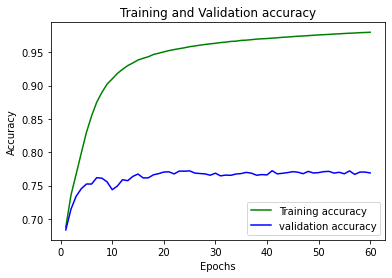

In [134]:
loss_train = myfl['accuracy_function']
loss_val = myfl['val_accuracy_function']
epochs = range(1,61)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

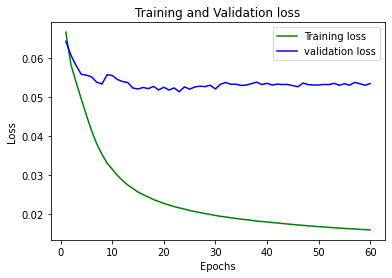

In [135]:
loss_train = myfl['loss']
loss_val = myfl['val_loss']
epochs = range(1,61)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [136]:
from tensorflow.keras.models import load_model
new_model2 =load_model('atunet3.h5', 
                      custom_objects = {'loss_function':loss_function,'accuracy_function':accuracy_function})


In [137]:
print(new_model2.summary())

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 15, 15, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 15, 15, 1024  9438208     ['activation_8[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 15, 15, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

 add_1 (Add)                    (None, 30, 30, 256)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'conv2d_18[0][0]']              
                                                                                                  
 activation_16 (Activation)     (None, 30, 30, 256)  0           ['add_1[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 30, 30, 1)    257         ['activation_16[0][0]']          
                                                                                                  
 activation_17 (Activation)     (None, 30, 30, 1)    0           ['conv2d_20[0][0]']              
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 60, 60, 1)   0           ['activation_17[0][0]']          
          

 conv2d_29 (Conv2D)             (None, 120, 120, 12  442496      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 120, 120, 12  512        ['conv2d_29[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_23 (Activation)     (None, 120, 120, 12  0           ['batch_normalization_20[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 120, 120, 12  147584      ['activation_23[0][0]']          
          

                                                                                                  
 conv2d_38 (Conv2D)             (None, 240, 240, 1)  65          ['activation_29[0][0]']          
                                                                                                  
 batch_normalization_26 (BatchN  (None, 240, 240, 1)  4          ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_30 (Activation)     (None, 240, 240, 1)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
Total params: 37,334,665
Trainable params: 37,319,047
Non-trainable params: 15,618
__________________________________________________________________________________________________
None


In [138]:
new_model2.load_weights('atucheck3.h5')

In [139]:
import numpy as np
from zipfile import ZipFile
from io import BytesIO

def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}
data = extract_zip('nyu_test.zip')
    
my_rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
my_depth = np.load(BytesIO(data['eigen_test_depth.npy']))
test_crop = np.load(BytesIO(data['eigen_test_crop.npy']))
print('Test data loaded.\n')

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth, maxDepth, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return predictions
    #return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth
    
    
test_rgb = tf.image.resize(my_rgb,[240,240])
im = tf.expand_dims(my_depth, axis=3)
test_depth = tf.image.resize(im,[240,240])/10

test_pred = predict(new_model2,test_rgb/255, minDepth=10 ,maxDepth=1000, batch_size=6)

def compute_errors(gt, pred):
    err_name = ['a1','a2','a3','abs_rel','rmse','log_10']
    err_val = []
    
    thresh = np.maximum((gt / pred), (pred / gt))
        
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(np.mean(rmse))

    log_10 = np.mean((np.abs(np.log10(gt)-np.log10(pred))))
    
    err_val.extend([a1,a2,a3,abs_rel,rmse,log_10])
    
    
    d = dict(zip(err_name,err_val))
    
    for k,v in d.items():
        print(f"{k} : {v}")
        
compute_errors(test_depth, test_pred)
        


Test data loaded.

109/109 [==============================] - 767s 7s/step
a1 : 0.2996883229272851
a2 : 0.5595355770047571
a3 : 0.7562197640587836
abs_rel : 0.5099974274635315
rmse : 0.16206492483615875
log_10 : 0.20093373954296112


Text(0.5, 1.0, 'Predicted_Depth')

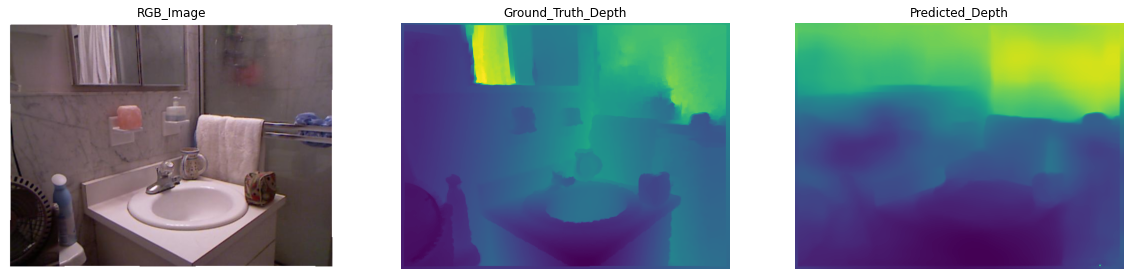

In [140]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Resizing Predicted Image
test_pre = tf.image.resize(test_pred,[480,640])
  
# reading images
Image1 = my_rgb[0,:,:,:]
Image2 = my_depth[0,:,:]
Image3 = test_pre[0,:,:,:]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("RGB_Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Ground_Truth_Depth")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Predicted_Depth")

1/1 [==============================] - 1s 919ms/step


Text(0.5, 1.0, 'Predicted_Depth')

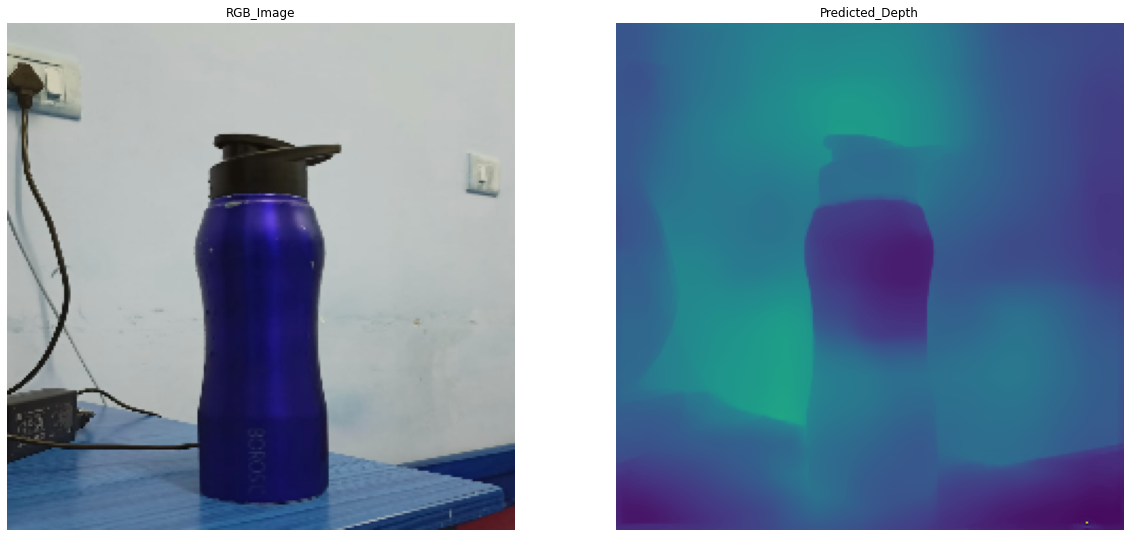

In [142]:
# code for displaying multiple images in one figure

import cv2
#img = cv2.imread(r"C:\Users\hp\Downloads\IMG_20230308_105243.jpg")
img = cv2.imread(r"C:\Users\hp\Downloads\botle.jpg")


my_img = tf.image.resize(img,[240,240])/255
my_img = tf.expand_dims(my_img, axis=0)
mypic_pred = predict(new_model2,my_img, minDepth=10 ,maxDepth=1000, batch_size=1)
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
Image1 = my_img[0,:,:,:]
Image2 = mypic_pred[0,:,:,:]


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("RGB_Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Predicted_Depth")
  

# 

# <center>3. Attention Residual UNet

In [52]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

In [53]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    #print(model.summary())
    return model

In [ ]:
from datetime import datetime
input_img = (240,240, 3)
#model = Attention_UNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)
model = Attention_ResUNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('atresu_check2.h5', save_best_only=True, verbose=1)

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 5
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

csv_log = tf.keras.callbacks.CSVLogger('atresu_log2.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,csv_log] #reduce_lr, early_stopping]
#model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs=3  ,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('atresunet2.h5')

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 240, 240, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 240, 240, 64  256        ['conv2d_48[0][0]']              
 ormalization)                  )                                                  

                                                                  'batch_normalization_43[0][0]'] 
                                                                                                  
 activation_36 (Activation)     (None, 60, 60, 256)  0           ['add_15[0][0]']                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 30, 30, 256)  0          ['activation_36[0][0]']          
                                                                                                  
 conv2d_57 (Conv2D)             (None, 30, 30, 512)  1180160     ['max_pooling2d_6[0][0]']        
                                                                                                  
 batch_normalization_45 (BatchN  (None, 30, 30, 512)  2048       ['conv2d_57[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 multiply_4 (Multiply)          (None, 30, 30, 512)  0           ['lambda_4[0][0]',               
                                                                  'activation_38[0][0]']          
                                                                                                  
 conv2d_67 (Conv2D)             (None, 30, 30, 512)  262656      ['multiply_4[0][0]']             
                                                                                                  
 up_sampling2d_9 (UpSampling2D)  (None, 30, 30, 1024  0          ['activation_40[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 30, 30, 512)  2048       ['conv2d_67[0][0]']              
 ormalizat

                                                                                                  
 activation_49 (Activation)     (None, 60, 60, 256)  0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 60, 60, 256)  196864      ['concatenate_5[0][0]']          
                                                                                                  
 conv2d_77 (Conv2D)             (None, 60, 60, 256)  590080      ['activation_49[0][0]']          
                                                                                                  
 batch_normalization_60 (BatchN  (None, 60, 60, 256)  1024       ['conv2d_78[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 add_23 (Add)                   (None, 120, 120, 12  0           ['batch_normalization_65[0][0]', 
                                8)                                'batch_normalization_64[0][0]'] 
                                                                                                  
 activation_55 (Activation)     (None, 120, 120, 12  0           ['add_23[0][0]']                 
                                8)                                                                
                                                                                                  
 conv2d_87 (Conv2D)             (None, 120, 120, 64  8256        ['activation_55[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_66 (BatchN  (None, 120, 120, 64  256        ['conv2d_87[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_71 (BatchN  (None, 240, 240, 1)  4          ['conv2d_95[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_61 (Activation)     (None, 240, 240, 1)  0           ['batch_normalization_71[0][0]'] 
                                                                                                  
Total params: 39,090,377
Trainable params: 39,068,871
Non-trainable params: 21,506
__________________________________________________________________________________________________
None

Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/3


2023-05-05 16:11:55.298145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/loss_function/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5068/5068 [==============================] - ETA: 0s - loss: 0.0646 - accuracy_function: 0.7015
Epoch 1: val_loss improved from inf to 0.06060, saving model to atresu_check2.h5
5068/5068 [==============================] - 1581s 310ms/step - loss: 0.0646 - accuracy_function: 0.7015 - val_loss: 0.0606 - val_accuracy_function: 0.7092 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00016.
Epoch 2/3
5068/5068 [==============================] - ETA: 0s - loss: 0.0566 - accuracy_function: 0.7467
Epoch 2: val_loss improved from 0.06060 to 0.05900, saving model to atresu_check2.h5
5068/5068 [==============================] - 1563s 308ms/step - loss: 0.0566 - accuracy_function: 0.7467 - val_loss: 0.0590 - val_accuracy_function: 0.7292 - lr: 1.6000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00012.
Epoch 3/3
5068/5068 [==============================] - ETA: 0s - loss: 0.0515 - accuracy_function: 0.7831

In [38]:
from datetime import datetime
input_img = (240,240, 3)
#model = Attention_UNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)
model = Attention_ResUNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('atresu_check1.h5', save_best_only=True, verbose=1)

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 5
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

csv_log = tf.keras.callbacks.CSVLogger('atresu_log.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,csv_log] #reduce_lr, early_stopping]
#model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs= 3 ,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('atresunet.h5')

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 240, 240, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_55 (BatchN  (None, 240, 240, 64  256        ['conv2d_67[0][0]']              
 ormalization)                  )                                                  

                                                                  'batch_normalization_62[0][0]'] 
                                                                                                  
 activation_55 (Activation)     (None, 60, 60, 256)  0           ['add_15[0][0]']                 
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 30, 30, 256)  0          ['activation_55[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 30, 30, 512)  1180160     ['max_pooling2d_10[0][0]']       
                                                                                                  
 batch_normalization_64 (BatchN  (None, 30, 30, 512)  2048       ['conv2d_76[0][0]']              
 ormalizat

 )                                                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 30, 30, 512)  0           ['up_sampling2d_12[0][0]']       
                                                                                                  
 multiply_4 (Multiply)          (None, 30, 30, 512)  0           ['lambda_4[0][0]',               
                                                                  'activation_57[0][0]']          
                                                                                                  
 conv2d_86 (Conv2D)             (None, 30, 30, 512)  262656      ['multiply_4[0][0]']             
                                                                                                  
 up_sampling2d_13 (UpSampling2D  (None, 30, 30, 1024  0          ['activation_59[0][0]']          
 )        

                                                                                                  
 batch_normalization_77 (BatchN  (None, 60, 60, 256)  1024       ['conv2d_95[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_68 (Activation)     (None, 60, 60, 256)  0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_97 (Conv2D)             (None, 60, 60, 256)  196864      ['concatenate_9[0][0]']          
                                                                                                  
 conv2d_96 (Conv2D)             (None, 60, 60, 256)  590080      ['activation_68[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_83 (BatchN  (None, 120, 120, 12  512        ['conv2d_104[0][0]']             
 ormalization)                  8)                                                                
                                                                                                  
 add_23 (Add)                   (None, 120, 120, 12  0           ['batch_normalization_84[0][0]', 
                                8)                                'batch_normalization_83[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 120, 120, 12  0           ['add_23[0][0]']                 
                                8)                                                                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 120, 120, 64  8256        ['activation_74[0][0]']          
          

                                )                                                                 
                                                                                                  
 conv2d_114 (Conv2D)            (None, 240, 240, 1)  65          ['activation_79[0][0]']          
                                                                                                  
 batch_normalization_90 (BatchN  (None, 240, 240, 1)  4          ['conv2d_114[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_80 (Activation)     (None, 240, 240, 1)  0           ['batch_normalization_90[0][0]'] 
                                                                                                  
Total params: 39,090,377
Trainable params: 39,068,871
Non-trainable params: 21,506
__________________________

2023-05-05 12:55:31.963498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/loss_function/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5068/5068 [==============================] - ETA: 0s - loss: 0.0600 - accuracy_function: 0.7331
Epoch 1: val_loss improved from inf to 0.05862, saving model to atresu_check1.h5
5068/5068 [==============================] - 1578s 310ms/step - loss: 0.0600 - accuracy_function: 0.7331 - val_loss: 0.0586 - val_accuracy_function: 0.7368 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00016.
Epoch 2/5
5068/5068 [==============================] - ETA: 0s - loss: 0.0494 - accuracy_function: 0.7971
Epoch 2: val_loss improved from 0.05862 to 0.05764, saving model to atresu_check1.h5
5068/5068 [==============================] - 1571s 310ms/step - loss: 0.0494 - accuracy_function: 0.7971 - val_loss: 0.0576 - val_accuracy_function: 0.7417 - lr: 1.6000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00012.
Epoch 3/5
5068/5068 [==============================] - ETA: 0s - loss: 0.0426 - accuracy_function: 0.8445
Epoch 3: val_loss improved from 0.05764 to 0.055

In [39]:
pwd

'/home/ajay/MDE'

In [41]:
from tensorflow.keras.models import load_model
own_model = load_model('atresunet.h5',
                      custom_objects = {'loss_function':loss_function,'accuracy_function':accuracy_function})

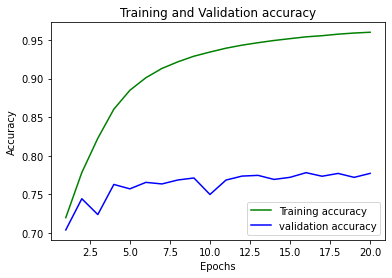

In [41]:
loss_train = myf['accuracy_function']
loss_val = myf['val_accuracy_function']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

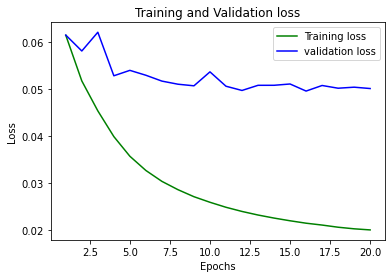

In [42]:
loss_train = myf['loss']
loss_val = myf['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
import numpy as np
from zipfile import ZipFile
from io import BytesIO

def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}
data = extract_zip('/home/ajay/nyu_test.zip')
    
my_rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
my_depth = np.load(BytesIO(data['eigen_test_depth.npy']))
test_crop = np.load(BytesIO(data['eigen_test_crop.npy']))
print('Test data loaded.\n')

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth, maxDepth, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return predictions
    #return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth
    
    
test_rgb = tf.image.resize(my_rgb,[240,240])
im = tf.expand_dims(my_depth, axis=3)
test_depth = tf.image.resize(im,[240,240])/10

test_pred = predict(own_model,test_rgb/255, minDepth=10 ,maxDepth=1000, batch_size=6)

def compute_errors(gt, pred):
    err_name = ['a1','a2','a3','abs_rel','rmse','log_10']
    err_val = []
    
    thresh = np.maximum((gt / pred), (pred / gt))
        
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(np.mean(rmse))

    log_10 = np.mean((np.abs(np.log10(gt)-np.log10(pred))))
    
    err_val.extend([a1,a2,a3,abs_rel,rmse,log_10])
    
    
    d = dict(zip(err_name,err_val))
    
    for k,v in d.items():
        print(f"{k} : {v}")
        
compute_errors(test_depth, test_pred)
        
#depth_scores = np.zeros((6, len(rgb)))

#e = depth_scores.mean(axis=1)

#print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
#print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))


#return f"a1 : {a1}, a2 : {a2}, a3 : {a3}, abs_rel : {abs_rel}, rmse : {rmse}, log_10 : {log_10}"

Test data loaded.

109/109 [==============================] - 7s 55ms/step
a1 : 0.3245444699286442
a2 : 0.595155373980632
a3 : 0.7940639865783214
abs_rel : 0.5110868215560913
rmse : 0.1630903035402298
log_10 : 0.18355277180671692


Text(0.5, 1.0, 'Predicted_Depth')

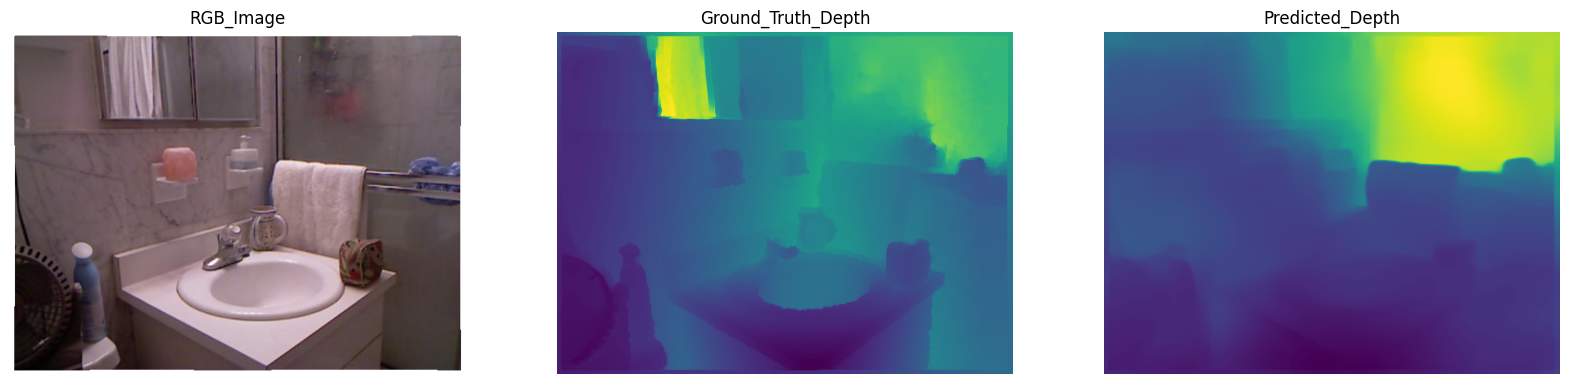

In [33]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Resizing Predicted Image
test_pre = tf.image.resize(test_pred,[480,640])
  
# reading images
Image1 = my_rgb[0,:,:,:]
Image2 = my_depth[0,:,:]
Image3 = test_pre[0,:,:,:]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("RGB_Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Ground_Truth_Depth")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Predicted_Depth")

1/1 [==============================] - 1s 973ms/step


Text(0.5, 1.0, 'Predicted_Depth')

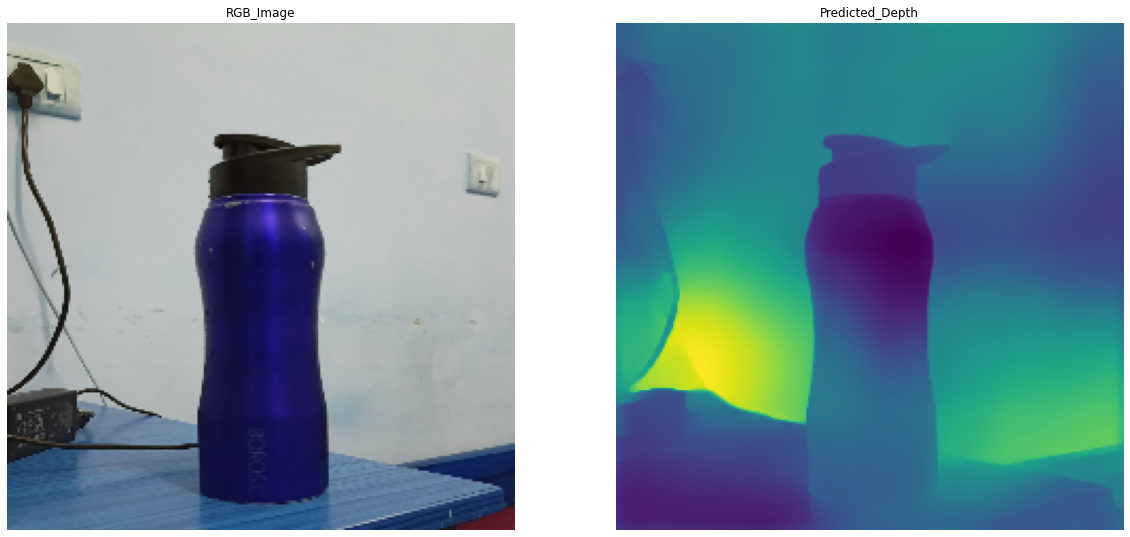

In [28]:
# code for displaying multiple images in one figure

import cv2
#img = cv2.imread(r"C:\Users\hp\Downloads\IMG_20230308_105243.jpg")
img = cv2.imread(r"C:\Users\hp\Downloads\botle.jpg")


my_img = tf.image.resize(img,[240,240])/255
my_img = tf.expand_dims(my_img, axis=0)
mypic_pred = predict(own_model,my_img, minDepth=10 ,maxDepth=1000, batch_size=1)
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
Image1 = my_img[0,:,:,:]
Image2 = mypic_pred[0,:,:,:]


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("RGB_Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Predicted_Depth")
  

# 

# <center>4. UNet ++ 

In [22]:
import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input,Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers import ELU, LeakyReLU
#from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout
import numpy as np
import cv2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
#from keras_unet_collection import models

In [ ]:
# Unet Plus
model_Unet_plus = models.unet_plus_2d((240, 240, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=1, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet_plus')




checkpoint = tf.keras.callbacks.ModelCheckpoint('upp_check2.h5', save_best_only=True, verbose=1)


#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 70
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

upplog2 = tf.keras.callbacks.CSVLogger('upp2_log.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,upplog2] #reduce_lr, early_stopping]


model_Unet_plus.compile(loss=loss_function, optimizer= opt, 
              metrics=[accuracy_function])

print(model_Unet_plus.summary())

start = datetime.now() 

Unet_plus_history = model_Unet_plus.fit(train_generator,
                    validation_data= val_generator,
                    epochs=50,callbacks=callbacks)

stop = datetime.now()
#Execution time of the model 
print(stop-start)


model_Unet_plus.save('unetpp2.h5')

In [30]:
from tensorflow.keras.models import load_model
my_model =load_model('unetpp2.h5', 
                      custom_objects = {'loss_function':loss_function,'accuracy_function':accuracy_function})

In [31]:
my_model.load_weights('upp_check2.h5')

In [36]:
mydf = pd.read_csv('upp2_log.csv')

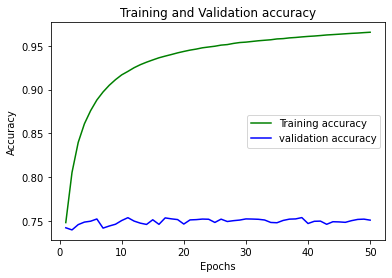

In [37]:
loss_train = mydf['accuracy_function']
loss_val = mydf['val_accuracy_function']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

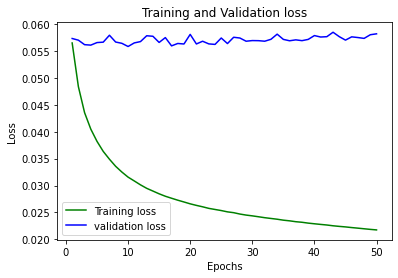

In [38]:
loss_train = mydf['loss']
loss_val = mydf['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
import numpy as np
from zipfile import ZipFile
from io import BytesIO

def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}
data = extract_zip('nyu_test.zip')
    
my_rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
my_depth = np.load(BytesIO(data['eigen_test_depth.npy']))
test_crop = np.load(BytesIO(data['eigen_test_crop.npy']))
print('Test data loaded.\n')

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth, maxDepth, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return predictions
    #return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth
    
    
test_rgb = tf.image.resize(my_rgb,[240,240])
im = tf.expand_dims(my_depth, axis=3)
test_depth = tf.image.resize(im,[240,240])/10

test_pred = predict(my_model,test_rgb/255, minDepth=10 ,maxDepth=1000, batch_size=6)

def compute_errors(gt, pred):
    err_name = ['a1','a2','a3','abs_rel','rmse','log_10']
    err_val = []
    
    thresh = np.maximum((gt / pred), (pred / gt))
        
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(np.mean(rmse))

    log_10 = np.mean(np.abs(np.log10(gt)-np.log10(pred)))
    
    err_val.extend([a1,a2,a3,abs_rel,rmse,log_10])
    
    
    d = dict(zip(err_name,err_val))
    
    for k,v in d.items():
        print(f"{k} : {v}")
        
compute_errors(test_depth, test_pred)
        
#depth_scores = np.zeros((6, len(rgb)))

#e = depth_scores.mean(axis=1)

#print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))

Test data loaded.

109/109 [==============================] - 526s 5s/step
a1 : 0.31682965936119606
a2 : 0.5821913757220524
a3 : 0.7842813190197078
abs_rel : 0.604554295539856
rmse : 0.17865042388439178
log_10 : 0.18761688470840454


Text(0.5, 1.0, 'Predicted_Depth')

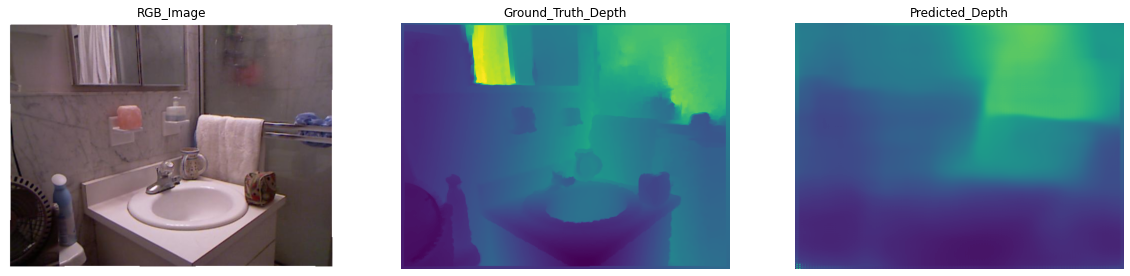

In [33]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Resizing Predicted Image
test_pre = tf.image.resize(test_pred,[480,640])
  
# reading images
Image1 = my_rgb[0,:,:,:]
Image2 = my_depth[0,:,:]
Image3 = test_pre[0,:,:,:]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("RGB_Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Ground_Truth_Depth")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Predicted_Depth")

1/1 [==============================] - 1s 674ms/step


Text(0.5, 1.0, 'Predicted_Depth')

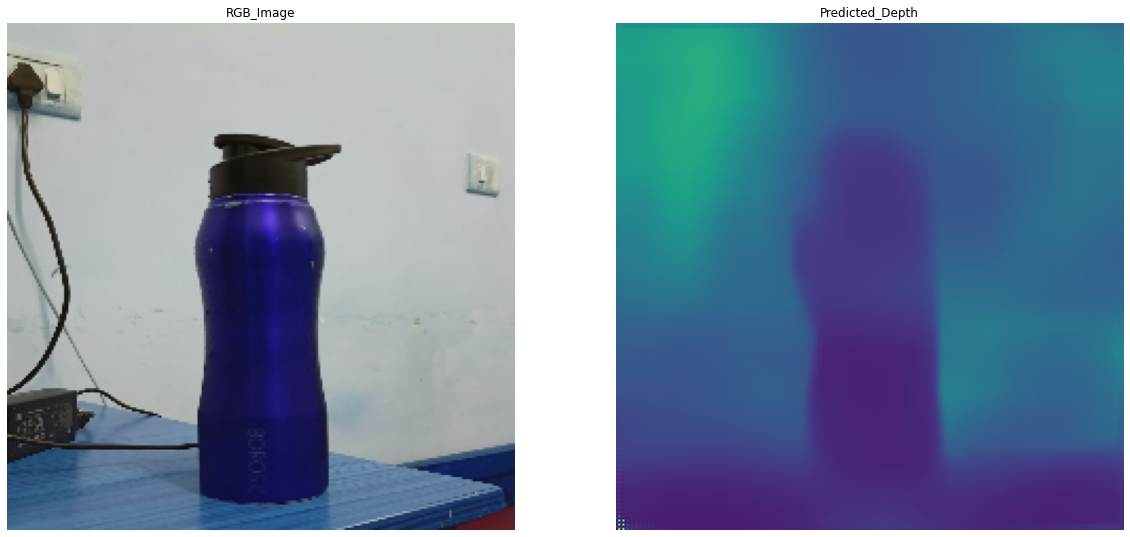

In [35]:
# code for displaying multiple images in one figure

import cv2
#img = cv2.imread(r"C:\Users\hp\Downloads\IMG_20230308_105243.jpg")
img = cv2.imread(r"C:\Users\hp\Downloads\botle.jpg")


my_img = tf.image.resize(img,[240,240])/255
my_img = tf.expand_dims(my_img, axis=0)
mypic_pred = predict(my_model,my_img, minDepth=10 ,maxDepth=1000, batch_size=1)
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
Image1 = my_img[0,:,:,:]
Image2 = mypic_pred[0,:,:,:]


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("RGB_Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Predicted_Depth")
  